## Import libraires and datasets

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import random as random
import math
from sklearn.model_selection import train_test_split

## Import and Process Training and Test Data

In [3]:
# Working
def init_proc(df):
    dummies = pd.get_dummies(df['LeagueId'],dtype='int32')
    df = df.join(dummies)
    df = df.set_index(pd.to_datetime(df['Date'], dayfirst=True))
    df['Year'] = df.index.year
    df['Day'] = df.index.day_of_year
    df.columns = df.columns.astype(str)
    return df


train = init_proc(pd.read_csv('train.csv'))
test = init_proc(pd.read_csv('test.csv'))

# Set avg goals and corners for each team, diff when they are home and away
for side in ['Home','Away']:
    idcol = side + 'TeamId'
    incols = [side + '_Goals',side + '_Corners']
    outcols = [side+'_Avg_Goals',side+'_Avg_Corners']

    for year in train['Year'].unique():
        for teamid in train.loc[train['Year'] == year, idcol].unique():
            means = train.query(f'{idcol} == {teamid} and Year == {year}')[incols].mean().values
            train.loc[(train[idcol] == teamid) & (train['Year'] == year),outcols] = means

# Make target column at end
train['Total_Corners'] = train['Home_Corners'] + train['Away_Corners']

# Merge average statistics from latest season into test df
for side in ['Home','Away']:
    idcol = side + 'TeamId'
    outcols = [side+'_Avg_Goals',side+'_Avg_Corners']

    for teamid in test[idcol].unique():
        test.loc[test[idcol] == teamid,outcols] = train.query( \
            f'{idcol} == {teamid}')[outcols].tail(1).values[0]

# Add extra columns to 'test' that were not one-hot encoded and set to 0
# (remember to exclude matches from test that occured in a league that the model
# could not be trained on, like 811) 
test.loc[:,[str(league) for league in train['LeagueId'].unique() if 
      (league not in test['LeagueId'].unique() and league not in test.columns)]] = 0

# Drop unnecessary columns
train = train.drop(columns=['Date','MatchId','LeagueId',
             'HomeTeamId','AwayTeamId','Home_Goals',
             'Away_Goals','Home_Corners','Away_Corners'])
test = test.drop(columns=['Date','MatchId','LeagueId',
             'HomeTeamId','AwayTeamId','Unnamed: 8'])


## Try XGBoost

In [4]:
# XGB Trainer
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning
# reg = xgb.XGBRegressor()
# param_grid = {"max_depth":    [4, 5, 6],
#               "n_estimators": [500, 600, 700],
#               "learning_rate": [0.01, 0.015, .001]}
# search = GridSearchCV(reg, param_grid, cv=5).fit(X_train, y_train)
# print("The best hyperparameters are ",search.best_params_)
# -> The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}

X_train,X_test,y_train,y_test = train_test_split(train[train.columns[:-1]],train['Total_Corners'], test_size = 0.2)

regressor = xgb.XGBRegressor(learning_rate = .01, n_estimators = 500,max_depth = 4, early_stopping_rounds=10)

regressor.fit(X_train, y_train, eval_set=[(X_test,y_test)], verbose=100)
predictions = regressor.predict(X_test)

[0]	validation_0-rmse:3.38039
[100]	validation_0-rmse:3.25868
[200]	validation_0-rmse:3.24025
[300]	validation_0-rmse:3.23765
[316]	validation_0-rmse:3.23763


### XGB Importance

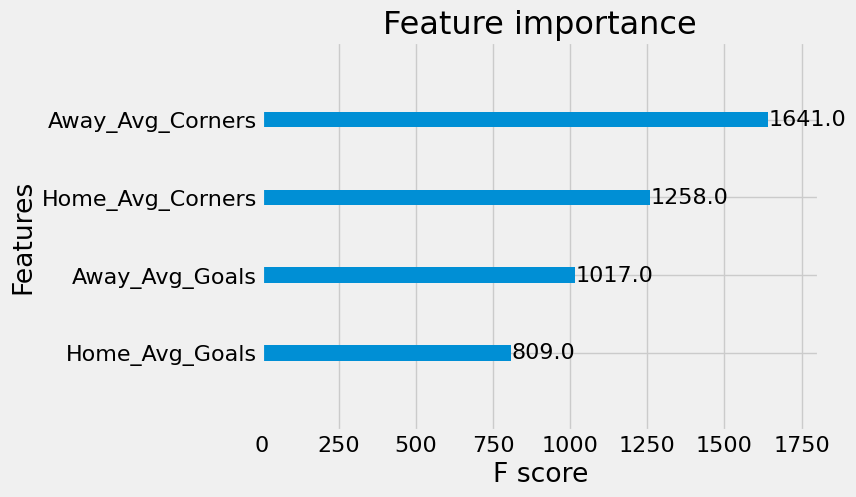

In [287]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots()
plot_importance(regressor, max_num_features=4, ax=ax)
plt.show()

### XGBoost Score

In [292]:
from sklearn.metrics import r2_score
r2_score(y_test,predictions)

0.0452038301468749

## Try other regression models

In [297]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from statistics import mean

#X_train,X_test,y_train,y_test = train_test_split(train[train.columns[:-1]],train['Total_Corners'], test_size = 0.2)
X = train[train.columns[:-1]]
y = train['Total_Corners']

models = {}
models['lasso'] = linear_model.LassoCV()
models['enet'] = linear_model.ElasticNetCV()
models['ridge'] = linear_model.RidgeCV()
models['svr_lin'] = make_pipeline(StandardScaler(),SVR(kernel='linear'))
models['svr_rbf'] = make_pipeline(StandardScaler(),SVR(kernel='rbf'))
models['GBR'] = ensemble.GradientBoostingRegressor()
models['RFR'] = ensemble.RandomForestRegressor()

for model in models.keys():
    models[model].fit(X,y)
    print(f'{model}: {models[model].score(X,y)}')

lasso: 0.04322950639996648
enet: 0.04347591968532738
ridge: 0.04374688291872464
svr_lin: 0.03914927869015772
svr_rbf: 0.04697368155246773
GBR: 0.06396748441577071
RFR: 0.46351013398568397


## Include year and date

In [42]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X = train[train.columns[:-1]]
y = train['Total_Corners']

models = {}
models['lasso'] = linear_model.LassoCV()
models['enet'] = linear_model.ElasticNetCV()
models['ridge'] = linear_model.RidgeCV()
models['GBR'] = ensemble.GradientBoostingRegressor()
models['RFR'] = ensemble.RandomForestRegressor()
models['svr_lin'] = make_pipeline(StandardScaler(),SVR(kernel='linear'))
models['svr_rbf'] = make_pipeline(StandardScaler(),SVR(kernel='rbf'))

for model in models.keys():
    models[model].fit(X,y)
    print(f'{model}: {models[model].score(X,y)}')

lasso: 0.09324627052171064
enet: 0.09317936414179373
ridge: 0.09350918229216798
GBR: 0.11535881129513692
RFR: 0.8636183268968293
svr_lin: 0.08950110641424336
svr_rbf: 0.10659819068369936


## Focus on RFR
### Hyperparameter tuning

In [47]:
# Tune hyperparameters of RFR
from sklearn.model_selection import GridSearchCV

random_grid = {'n_estimators':[100,200,300]}
rf = ensemble.RandomForestRegressor()
rf_random = GridSearchCV(estimator = rf, param_grid = random_grid, 
                               cv = 5, verbose=2, n_jobs = -1)
rf_random.fit(X,y)
rf_random.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


{'n_estimators': 300}

### Feature importance

In [107]:
for i in zip(X.columns,rf.feature_importances_):
    print(i)

('729', 0.009293128472128164)
('734', 0.006866243936762201)
('741', 0.008573709634650317)
('764', 0.0047969729490815695)
('776', 0.006655973496909176)
('781', 0.00666665474535262)
('793', 0.009454117666311934)
('795', 0.006674499503214684)
('800', 0.008982612294156707)
('801', 0.008648390198603341)
('811', 0.008814470622659209)
('813', 0.007839480541366371)
('816', 0.009023681395113134)
('Year', 0.043428508394708576)
('Day', 0.20563930145155523)
('Home_Avg_Goals', 0.14124404824948095)
('Home_Avg_Corners', 0.18686795974905543)
('Away_Avg_Goals', 0.14345996870575245)
('Away_Avg_Corners', 0.17707027799313788)


### Final tuned RFR model

In [41]:
from sklearn import ensemble
# estimators: 100: 86.4%, 300: 86.8%, 500: 86.9%
X = train[train.columns[:-1]]
y = train['Total_Corners']
rf = ensemble.RandomForestRegressor(n_estimators=300)
rf.fit(X,y)
print(rf.score(X,y))

0.867412126873927


## Run predictions

In [7]:
test['Predictions'] = rf.predict(test[X.columns])
test[['Line','Predictions']]

,Line,Predictions
Date,,
2011-04-01,9.5,10.354
2011-04-01,11.5,13.006
2011-04-01,10.5,11.422
2011-04-01,11.0,10.856
2011-04-01,12.0,13.528
...,...,...
2011-05-22,10.5,11.130
2011-05-22,10.0,10.990
2011-05-22,10.0,9.386


## Stake Calculator

In [72]:
def calc_probs(row):
    row['P(Under)'] = np.sum([ \
        (row['Predictions']**i * np.exp(-1*row['Predictions'])) \
          / math.factorial(i) for i in range(math.ceil(row['Line']))])
    
    if row['Line'] % 1 == 0:
        row['P(At)'] = row['Predictions']**row['Line'] * np.exp(-1*row['Predictions']) \
          / math.factorial(int(row['Line']))
    else:
        row['P(At)'] = 0

    row['P(Over)'] = 1 - np.sum(row[['P(Under)','P(At)']])

    return row[['P(Under)','P(At)','P(Over)']]

def bet_stake(row):
    # Kelly Criterion: (p - q/b)/(1 - push)
    factor = 1
    stake_over = factor * (row['P(Over)'] - row['P(Under)'] / (row['Over'] - 1)) / (1 - row['P(At)'])
    stake_under = factor * (row['P(Under)'] - row['P(Over)'] / (row['Under'] - 1)) / (1 - row['P(At)'])
    if max(stake_over,stake_under) > 0.25:
        if stake_under > stake_over:
            row[['Bet (U/O)','Stake']] = ['U',stake_under]
        else:
            row[['Bet (U/O)','Stake']] = ['O',stake_over]
    return row[['Bet (U/O)','Stake']]
    
test[['P(Under)','P(At)','P(Over)','Bet (U/O)','Stake']] = np.NaN
test[['P(Under)','P(At)','P(Over)']] = test.apply(calc_probs,axis=1)
test[['Bet (U/O)','Stake']] = test.apply(bet_stake,axis=1)
test['Stake'] = round(test['Stake'] * (341/test['Stake'].sum())) # scale stakes to available funds

print(test['Stake'].sum())
print(test['Stake'].describe())
#print(test['Bet (U/O)'].value_counts())
test

340.0
count    99.000000
mean      3.434343
std       1.318329
min       2.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       7.000000
Name: Stake, dtype: float64


,Line,Over,Under,P(Under),P(At),P(Over),Bet (U/O),Stake,729,741,...,Home_Avg_Corners,Away_Avg_Goals,Away_Avg_Corners,781,800,816,734,764,813,Predictions
Date,,,,,,,,,,,,,,,,,,,,,
2011-04-01,9.5,1.790,1.800,0.414495,0.000000,0.585505,NaN,NaN,0,1,...,6.684211,2.736842,4.789474,0,0,0,0,0,0,10.354
2011-04-01,11.5,1.920,2.000,0.352556,0.000000,0.647444,O,2.0,0,1,...,5.722222,0.894737,5.000000,0,0,0,0,0,0,13.006
2011-04-01,10.5,1.970,1.870,0.410583,0.000000,0.589417,NaN,NaN,1,0,...,6.000000,1.055556,4.111111,0,0,0,0,0,0,11.422
2011-04-01,11.0,2.075,1.770,0.477187,0.119265,0.403548,NaN,NaN,1,0,...,7.739130,1.947368,6.368421,0,0,0,0,0,0,10.856
2011-04-01,12.0,2.020,1.860,0.301850,0.104552,0.593599,O,3.0,0,1,...,7.222222,0.947368,4.684211,0,0,0,0,0,0,13.528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-05-22,10.5,1.950,1.961,0.444464,0.000000,0.555536,NaN,NaN,1,0,...,6.000000,1.333333,6.166667,0,0,0,0,0,0,11.130
2011-05-22,10.0,1.920,1.909,0.341597,0.119486,0.538917,NaN,NaN,0,0,...,5.941176,1.000000,3.529412,0,0,0,0,0,0,10.990
2011-05-22,10.0,2.020,1.840,0.536688,0.122675,0.340638,NaN,NaN,0,0,...,6.368421,0.947368,3.052632,0,0,0,0,0,0,9.386
